In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import utils
import dataloaders
import torchvision
from trainer import Trainer
torch.random.manual_seed(0)
np.random.seed(0)

### Dataset

In [2]:
# Load the dataset and print some stats
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")

  0%|          | 49152/9912422 [00:00<00:23, 423644.26it/s]

 94%|█████████▍| 9314304/9912422 [00:00<00:00, 2918175.70it/s]

Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw





c:\Users\Acer\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw
Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw
Processing...
Done!
The tensor containing the images has shape: torch.Size([64, 1, 28, 28]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: 0.0


9920512it [00:20, 2918175.70it/s]                             


In [3]:
def create_model():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Flatten(), # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(28*28*1, 10)
        # No need to include softmax, as this is already combined in the loss function
    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model = create_model()

In [4]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

32768it [08:34, 63.63it/s]
1654784it [08:34, 3213.59it/s]   
8192it [08:34, 15.92it/s]


Output shape: torch.Size([64, 10])


### Hyperparameters & Loss function

In [5]:
# Hyperparameters
learning_rate = .0192
num_epochs = 5


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)

### Train model

In [6]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict, test_loss_dict = trainer.train(num_epochs)

Training epoch 4: 100%|██████████| 938/938 [00:08<00:00, 115.16it/s]


9920512it [15:35, 10603.21it/s]  


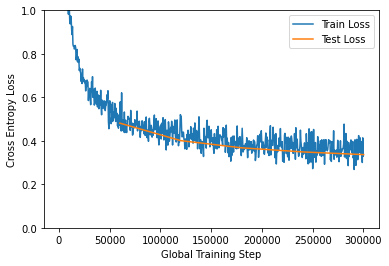

Final Test loss: 0.3365933203440943. Final Test accuracy: 0.9089


In [7]:
# We can now plot the training loss with our utility script

# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss")
utils.plot_loss(test_loss_dict, label="Test Loss")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4a.png")

plt.show()

torch.save(model.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

## Plotting example

In [8]:
# You can delete the remaining code of this notebook, as this is just to illustrate one method to solve the assignment tasks.


# This example code is here to illustrate how you can plot two different models to compare them.
# Lets change a small part of our model: the number of epochs trained (NOTE, use 5 epochs for your experiments in the assignment.)

# We reset the manual seed to 0, such that the model parameters are initialized with the same random number generator.
torch.random.manual_seed(0)
np.random.seed(0)


dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
model = create_model()

learning_rate = .0192
num_epochs = 6

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_6epochs, test_loss_dict_6epochs = trainer.train(num_epochs)
num_epochs = 5

Training epoch 5: 100%|██████████| 938/938 [00:08<00:00, 114.45it/s]


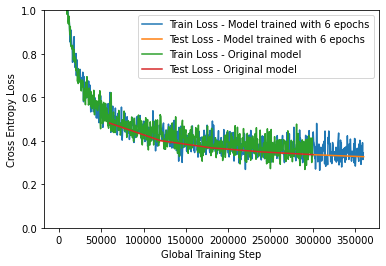

Final Test loss: 0.32694546403778585. Final Test accuracy: 0.9098


In [9]:
# We can now plot the two models against eachother

# Plot loss
utils.plot_loss(train_loss_dict_6epochs, label="Train Loss - Model trained with 6 epochs")
utils.plot_loss(test_loss_dict_6epochs, label="Test Loss - Model trained with 6 epochs")
utils.plot_loss(train_loss_dict, label="Train Loss - Original model")
utils.plot_loss(test_loss_dict, label="Test Loss - Original model")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4a.png")

plt.show()

torch.save(model.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

### Task A

### Task B

### Task C

### Task D